In [1]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import TrainingArguments
from datasets import Dataset, DatasetDict

c:\Users\Lakhal Badr\Desktop\projects\real-time-analytics-of-republican\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.chdir('..')
from src.utils.get_config import get_config
CONFIG_FILE = "./config/bert_config.yml"

DATA_PATH = get_config(CONFIG_FILE, "DATA_PATH")
SAVE_MODEL = get_config(CONFIG_FILE, "SAVE_MODEL")
MODEL = get_config(CONFIG_FILE, "MODEL")

In [3]:
data = pd.read_csv(DATA_PATH)
data.head()

,Unnamed: 0,text,fear,optimism,neutral
0,0,It hurts to snap out of that denial and face t...,1,0,0
1,1,"Yes, listening to loud noises can damage your ...",1,0,0
2,2,I'm assuming OP is female and the other person...,0,1,0
3,3,Watch the [NAME] fanbois raging on the thread.,0,0,1
4,4,Same thing happened to me last year ended horr...,1,0,0


In [4]:
# skiping unnecessary columns
columns_to_keep = ["text", "fear", "optimism", "neutral"]
data = data[columns_to_keep]
data.head()

,text,fear,optimism,neutral
0,It hurts to snap out of that denial and face t...,1,0,0
1,"Yes, listening to loud noises can damage your ...",1,0,0
2,I'm assuming OP is female and the other person...,0,1,0
3,Watch the [NAME] fanbois raging on the thread.,0,0,1
4,Same thing happened to me last year ended horr...,1,0,0


In [5]:
def get_category(row):
    if row['fear'] == 1:
        return "fear"
    elif row['optimism'] == 1:
        return "hope"
    elif row['neutral'] == 1:
        return "neutral"

In [6]:
data['category'] = data.apply(get_category, axis=1)
data = data[['text', 'category']]
data.head()

,text,category
0,It hurts to snap out of that denial and face t...,fear
1,"Yes, listening to loud noises can damage your ...",fear
2,I'm assuming OP is female and the other person...,hope
3,Watch the [NAME] fanbois raging on the thread.,neutral
4,Same thing happened to me last year ended horr...,fear


In [7]:
data.groupby('category')['text'].count()

category
fear       3150
hope       3150
neutral    3150
Name: text, dtype: int64

In [8]:
label_map = {"neutral": 0, "hope": 1, "fear": 2}
data["labels"] = data["category"].map(label_map)

temp = data.drop(columns=["category"])

train_data, temp_data = train_test_split(temp, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL)

dataset_tr = Dataset.from_pandas(train_data)
dataset_val = Dataset.from_pandas(val_data)
dataset_test = Dataset.from_pandas(test_data)

dataset = DatasetDict({
    "train": dataset_tr,
    "validation": dataset_val,
    "test": dataset_test
})

def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)

print(encoded_dataset['train'][0])

Map: 100%|██████████| 945/945 [00:00<00:00, 2228.47 examples/s]

{'text': 'Hope that helped. :P', 'labels': 1, '__index_level_0__': 7713, 'input_ids': [101, 3246, 2008, 3271, 1012, 1024, 1052, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(MODEL, num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",          # Directory for saving results
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    learning_rate=5e-5,              # Initial learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    num_train_epochs=1,              # Number of epochs
    weight_decay=0.01,               # Regularization
    logging_dir="./logs/bert_logs",  # Directory for logs
    logging_steps=10                 # Log every 10 steps
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Lakhal Badr\Desktop\projects\real-time-analytics-of-republican\.venv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
from transformers import Trainer

trainer = Trainer(
    model=model,                          # The DistilBERT model
    args=training_args,                   # Training arguments
    train_dataset=encoded_dataset['train'],  # Training data
    eval_dataset=encoded_dataset['validation']  # Validation data
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
predictions = trainer.predict(encoded_dataset['test'])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = encoded_dataset['test']['labels']

# Generate a classification report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       314
           1       0.76      0.76      0.76       304
           2       0.80      0.85      0.82       327

    accuracy                           0.76       945
   macro avg       0.75      0.75      0.75       945
weighted avg       0.75      0.76      0.75       945



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       314
           1       0.76      0.76      0.76       304
           2       0.80      0.85      0.82       327

    accuracy                           0.76       945
   macro avg       0.75      0.75      0.75       945
weighted avg       0.75      0.76      0.75       945


Confusion Matrix:
[[204  61  49]
 [ 50 232  22]
 [ 35  14 278]]


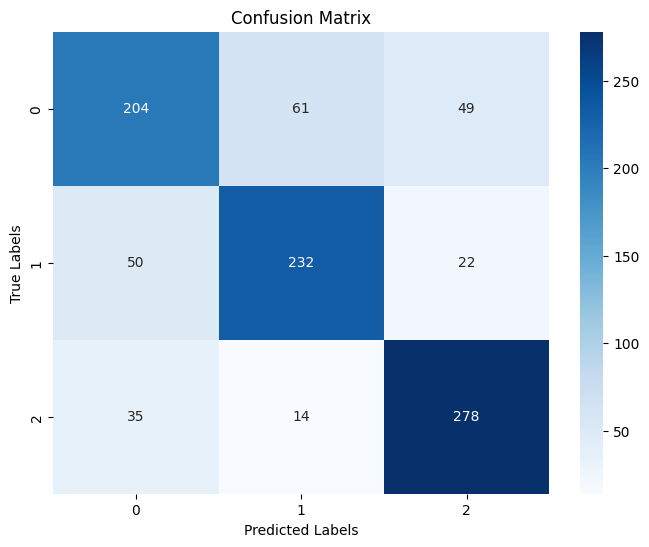

In [ ]:
predictions = trainer.predict(encoded_dataset['test'])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = encoded_dataset['test']['labels']
print("Accuracy:")
print(accuracy_score(true_labels, predicted_labels))

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

In [ ]:
model.save_pretrained(SAVE_MODEL)
tokenizer.save_pretrained(SAVE_MODEL)

('./fine_tuned_model\\tokenizer_config.json',
 './fine_tuned_model\\special_tokens_map.json',
 './fine_tuned_model\\vocab.txt',
 './fine_tuned_model\\added_tokens.json')